# Infer ***nucleus*** from the cytoplasm mask - 2️⃣ 
### Alternative workflow: ***"a"*** (an alternative workflow for images with NO **nuclei** or **cell membrane** makers)
--------------

## OVERVIEW
We will start by segmenting the different cell regions - the nucleus, cell, and cytoplasm - since they will be necessary for determining which organelle are in which cell. This is integral to our single cell analysis approach.

This notebook goes through the workflow steps to segment the ***nucleus*** from the cytoplasm mask generated in [01a_infer_cytoplasm_from-composite.ipynb](./01a_infer_cytoplasm_from-composite.ipynb).


## OBJECTIVE: 
### ✅ Infer sub-cellular component #2: ***nucleus***
Segment the ***nucleus*** from a the cytoplasm mask. The ***cellmask*** masks will be derived from this mask.



### IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Union, Tuple, List

import numpy as np

from scipy import ndimage as ndi
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_slice_by_slice )
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling

from skimage import filters
from skimage.segmentation import watershed, clear_border
from skimage.morphology import remove_small_holes, binary_dilation, binary_erosion 
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc.core.file_io import (read_czi_image,
                                     read_ome_image,
                                     import_inferred_organelle,
                                     export_inferred_organelle,
                                     list_image_files)

                                             
from infer_subc.core.img import *
from infer_subc.organelles import (get_nuclei, 
                                   get_cytoplasm,
                                   non_linear_cellmask_transform,
                                   choose_max_label_cellmask_union_nucleus)


%load_ext autoreload
%autoreload 2

## Get and load Image for processing

In [2]:
test_img_n = 0

data_root_path = Path(os.path.expanduser("~")) / "Documents/Python Scripts/Infer-subc-2D"

in_data_path = data_root_path / "neuron_raw_OME"
im_type = ".tiff"

img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

out_data_path = data_root_path / "neuron_raw_OME_out-06012023"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [3]:
img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\ome_types\_convenience.py:112: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


---------
## infer ***nucleus*** from composite image

### summary of steps

➡️ INPUT
- segmented cytoplasm object (from [01a_infer_cytoplasm_from-composite.ipynb](./01a_infer_cytoplasm_from-composite.ipynb))

PRE-PROCESSING
- binary dilation
- fill nucleus (hole size = user input)
- binary erosion

CORE-PROCESSING
- logical **XOR** of the cytoplasm and the filled in cytoplasm resulting in the nucleus and any artifacts from dilation/erosion


POST-PROCESSING
  - remove small objects (object size = user input)

OUTPUT ➡️ 
- save labeled ***nuclei*** (nucleus, NU) as unsigned integer 16-bit tif files

## EXTRACT prototype

In [4]:
###################
# INPUT
###################
cytoplasm_mask = import_inferred_organelle("cyto",meta_dict, out_data_path)

loaded  inferred 3D `cyto`  from C:\Users\Shannon\Documents\Python Scripts\Infer-subc-2D\neuron_raw_OME_out-06012023 


## PRE-PROCESSING prototype


In [5]:
###################
# PRE_PROCESSING
###################           
cytoplasm_dilated = binary_dilation(cytoplasm_mask)

hole_min_width = 0
hole_max_width = 500
small_obj_width = 0
fill_filter_method = "3D"
cytoplasm_filled = fill_and_filter_linear_size(cytoplasm_dilated, hole_min=hole_min_width, hole_max=hole_max_width, min_size=small_obj_width, method=fill_filter_method)

cytoplasm_eroded = binary_erosion(cytoplasm_filled)

## CORE PROCESSING prototype

In [6]:
###################
# CORE_PROCESSING
###################
nuclei_xor = np.logical_xor(cytoplasm_mask, cytoplasm_eroded)

## POST PROCESSING prototype

In [7]:
###################
# POST_PROCESSING
###################
nuc_small_object_width = 20

nuc_cleaned_img = fill_and_filter_linear_size(nuclei_xor, hole_min=0, hole_max=0, min_size=nuc_small_object_width, method="3D")

## LABELING prototype

In [8]:
###################
# LABELING
###################
# create instance segmentation based on connectivity
nuclei_labels = label_bool_as_uint16(nuc_cleaned_img)

In [9]:
nuclei_labels.dtype

dtype('uint16')

## Visualize with `napari` 1
Visualize the first-pass segmentation and labeling with `napari`.

In [10]:
viewer = napari.Viewer()

05-Jun-23 17:12:53 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1090x686+1221+334 (frame: 1108x733+1212+296) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1365x859+1222+341 (frame: 1383x906+1213+303) margins: 9, 38, 9, 9 minimum size: 612x589 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=630,636 maxtrack=0,0)


In [11]:
viewer.add_image(
    cytoplasm_mask)

viewer.add_labels(
    nuclei_labels)

<Labels layer 'nuclei_labels' at 0x2d41bbe1e10>

## SAVE inferred nuclei to .tif file


In [12]:
out_file_n = export_inferred_organelle(nuclei_labels, "nuc", meta_dict, out_data_path)

saved file: 20221027_C2-107_well_1_cell_1_untreated_Linear_unmixing_decon.ome-nuc


----------
## DEFINE `infer_nuclei_fromcytoplasm` function

Based on the _prototyping_ above define the function to infer nuclei. 

> NOTE: these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use.

In [13]:
##########################
#  _infer_nuclei_fromcytoplasm
##########################
def _infer_nuclei_fromcytoplasm(cytoplasm_mask: np.ndarray, 
                                nuc_min_hole_w: int,
                                nuc_max_hole_w: int,
                                nuc_fill_method: str,
                                small_obj_w: int,
                                fill_filter_method: str
                                ) -> np.ndarray:
    """
    Procedure to infer nuclei from linear unmixed input.

    Parameters
    ------------
    cytoplasm_mask: np.ndarray
        a 3d image of the cytoplasm segmentation
    max_hole_w: int
        hole filling cutoff to fill the nuclei
    small_obj_w: int
        object size cutoff to remove artifacts from dilation/erosion steps
    fill_filter_method: str
        to filter artifacts in "3D" or "slice-by-slice"

    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """

    ###################
    # PRE_PROCESSING
    ###################                
    cytoplasm_dilated = binary_dilation(cytoplasm_mask)

    cytoplasm_filled = fill_and_filter_linear_size(cytoplasm_dilated, 
                                                   hole_min=nuc_min_hole_w, 
                                                   hole_max=nuc_max_hole_w, 
                                                   min_size=0, 
                                                   method=nuc_fill_method)

    cytoplasm_eroded = binary_erosion(cytoplasm_filled)

    ###################
    # CORE_PROCESSING
    ###################
    nuclei_xor = np.logical_xor(cytoplasm_mask, cytoplasm_eroded)

    ###################
    # POST_PROCESSING
    ###################
    nuclei_object = fill_and_filter_linear_size(nuclei_xor, 
                                                hole_min=0, 
                                                hole_max=0, 
                                                min_size=small_obj_w,
                                                method=fill_filter_method)

    nuclei_labels = label_uint16(nuclei_object)

    return nuclei_labels

## DEFINE `_fixed_infer_nuclei_fromcytoplasm` function

Based on the _prototyping_ above define the function to infer cellmask. with a *fixed* set of parameters for each step in the procedure.  That is they are all "hard coded"

In [14]:
##########################
#  fixed_infer_nuclei_fromcytoplasm
##########################
def _fixed_infer_nuclei_fromcytoplasm(cytoplasm_mask: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing cytoplasm segmentation
 
    Returns
    -------------
    nuclei_object
        inferred nuclei
    
    """
    nuc_min_hole_w = 0
    nuc_max_hole_w = 500
    nuc_fill_method = "3D"
    small_obj_w = 20
    fill_filter_method = "3D"

    return _infer_nuclei_fromcytoplasm(cytoplasm_mask,
                                    nuc_min_hole_w,
                                    nuc_max_hole_w,
                                    nuc_fill_method,
                                    small_obj_w,
                                    fill_filter_method)


## TEST `_infer_nuclei_fromcytoplasm`  function defined above

In [15]:
_NU_object =  _fixed_infer_nuclei_fromcytoplasm(cytoplasm_mask) 

_NU_object.dtype

dtype('uint16')

In [16]:
np.all(nuclei_labels == _NU_object)

True

---------------------
# TEST `infer_nuclei_fromcytoplasm` exported functions

The prototype `_infer_nuclei_fromcytoplasm` was copied to the [`.organelles.nuclei`](../infer_subc/organelles/nuclei.py) sub-module.

In [17]:
from infer_subc.organelles.nuclei import infer_nuclei_fromcytoplasm, fixed_infer_nuclei_fromcytoplasm
nuclei_object =  fixed_infer_nuclei_fromcytoplasm(cytoplasm_mask) 

nuclei_object.dtype

dtype('uint16')

In [18]:
np.all(_NU_object == nuclei_object)

True

## Visualize  2


In [19]:
viewer.add_image(
    nuclei_object,
    opacity=0.3)

viewer.add_image(
    label(nuclei_object),
    opacity=0.3)

<Image layer 'Image' at 0x2d477b11ea0>

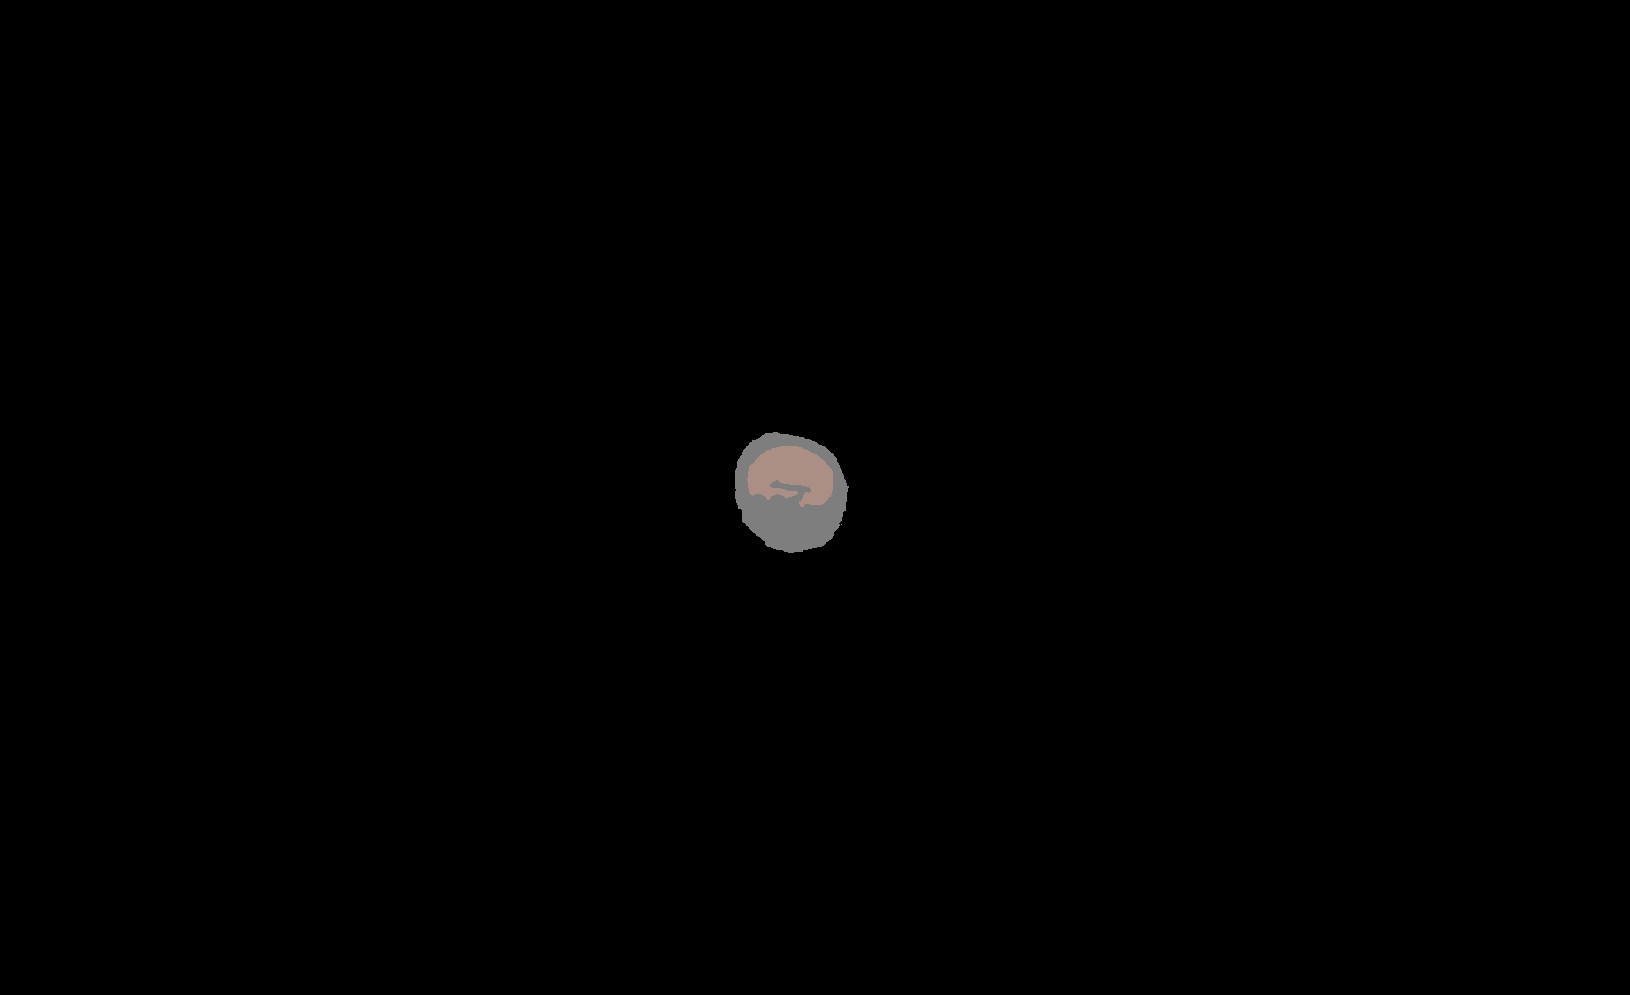

In [20]:
from napari.utils.notebook_display import nbscreenshot

nbscreenshot(viewer, canvas_only=True)

In [21]:
viewer.close()

-------------
## SUMMARY

The above explains the general procedure for segmenting the nucleus from a cytoplasm mask.

### NEXT: INFER CELLMASK from cytoplasm mask

proceed to [03a_infer_cellmask_from-cytoplasm.ipynb](./03a_infer_cellmask_from-cytoplasm.ipynb)
